## Loading and cleaning data

In [1]:
import pandas as pd
import random

In [2]:
# Dataset source: https://huggingface.co/datasets/ronaldahmed/scitechnews
df_train = pd.read_json('data/train.json', lines=True)
df_train.head()

,id,pr-title,pr-article,pr-summary,sc-title,sc-abstract,sc-section_names,sc-sections,sc-article,sc-authors
0,0,New York City's Vaccine Passport Plan Renews O...,When New York City announced on Tuesday that i...,New York's City's mandate that people must sho...,,,[],[],,[]
1,1,Facebook Disables Accounts Tied to NYU Researc...,Facebook Inc. has disabled the personal accoun...,Facebook has disabled the personal accounts of...,,,[],[],,[]
2,2,Teenage Girls in Northern Nigeria 'Open Their ...,"KANO, Nigeria, Aug 2 (Reuters) - Teenage girls...",The Kabara non-governmental organization (NGO)...,,,[],[],,[]
3,3,3D 'Heat Map' Animation Shows How Seizures Spr...,"For 29 years, from the time she was 12, Rashet...","University of California, San Francisco (UCSF)...",,,[],[],,[]
4,4,Endlessly Changing Playground Teaches AIs to M...,What did they learn? Some of DeepMind's XLand ...,Alphabet's DeepMind Technologies has developed...,,,[],[],,[]


Now keep only pertinent columns:

In [3]:
df_train = df_train[['pr-title', 'pr-article']]

df_train['pr-article'] = df_train['pr-article'].astype('string')
df_train['pr-title'] = df_train['pr-title'].astype('string')

df_train.head()

,pr-title,pr-article
0,New York City's Vaccine Passport Plan Renews O...,When New York City announced on Tuesday that i...
1,Facebook Disables Accounts Tied to NYU Researc...,Facebook Inc. has disabled the personal accoun...
2,Teenage Girls in Northern Nigeria 'Open Their ...,"KANO, Nigeria, Aug 2 (Reuters) - Teenage girls..."
3,3D 'Heat Map' Animation Shows How Seizures Spr...,"For 29 years, from the time she was 12, Rashet..."
4,Endlessly Changing Playground Teaches AIs to M...,What did they learn? Some of DeepMind's XLand ...


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26638 entries, 0 to 26637
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pr-title    26638 non-null  string
 1   pr-article  26638 non-null  string
dtypes: string(2)
memory usage: 416.3 KB


The dataset has empty article rows, which are not important for our task.

Remove empty articles (articles where title is all the info., so they don't need a new title)

In [5]:
df_train = df_train[df_train['pr-article'] != '']
print('Train dataframe size without blanks: ', len(df_train))

Train dataframe size without blanks:  12735


Print a random article and title:

In [6]:
random_article_idx = random.randint(0, len(df_train))
row = df_train.iloc[random_article_idx]
print('News example: ', random_article_idx)
print('Title:    \n', row['pr-title'])
print('Article:  \n', row['pr-article'])

News example:  7727
Title:    
 TC Study Finds MOOC Reality Not Yet Meeting High Expectations
Article:  
 The rollout of MOOCs, or massive open online courses, three years ago by some of the country's leading universities triggered predictions that bricks-and-mortar campuses would soon be obsolete and that learning would be forever changed.
Well, maybe - but not any time soon, according to one of the first comprehensive studies of MOOCs from the perspective of institutions, just released by researchers at Teachers College. The study is based on 83 interviews with faculty members, administrators, researchers, and other actors in the MOOCspace from 62 institutions, mostly in the U.S. It includes 13 case studies to illustrate how MOOCs are successfully being used to address institutional goals.
The study finds that a primary goal for institutions offering MOOCs is to extend institutional reach and access to education. "MOOCs are providing educational opportunities to millions of individua

See article lengths distribution (in chars and words):

Text(0, 0.5, 'Counts')

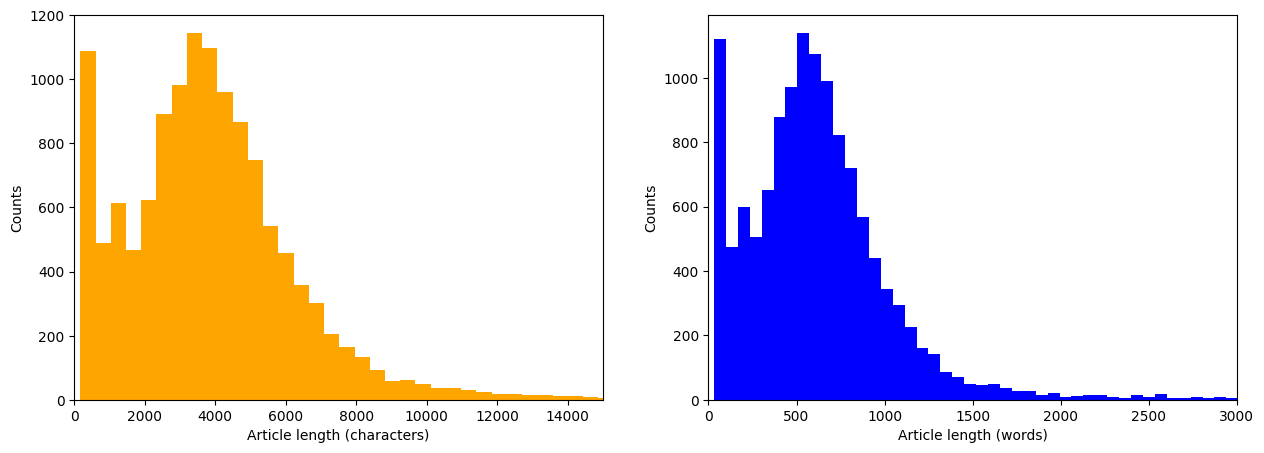

In [7]:
import matplotlib.pyplot as plt

article_lengths = df_train['pr-article'].str.len()
article_word_counts = df_train['pr-article'].str.split().str.len()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(article_lengths, bins=150, color='orange')
ax[0].set_xlim(0, 15000)
ax[0].set_xlabel('Article length (characters)')
ax[0].set_ylabel('Counts')

ax[1].hist(article_word_counts, bins=150, color='blue')
ax[1].set_xlim(0, 3000)
ax[1].set_xlabel('Article length (words)')
ax[1].set_ylabel('Counts')

Repeat cleaning process for valid and test datasets

In [8]:
df_valid = pd.read_json('data/valid.json', lines=True)
df_valid = df_valid[['pr-title', 'pr-article']]
df_valid['pr-article'] = df_valid['pr-article'].astype('string')
df_valid['pr-title'] = df_valid['pr-title'].astype('string')

df_test = pd.read_json('data/test.json', lines=True)
df_test = df_test[['pr-title', 'pr-article']]
df_test['pr-article'] = df_test['pr-article'].astype('string')
df_test['pr-title'] = df_test['pr-title'].astype('string')

print('Valid dataframe size: ', len(df_valid))
print('Test dataframe size:  ', len(df_test))

Valid dataframe size:  1431
Test dataframe size:   1000


In [9]:
df_valid = df_valid[df_valid['pr-article'] != '']
df_valid = df_valid[df_valid['pr-title'] != '']
print('Valid dataframe size without blanks: ', len(df_valid))
print('Test dataframe size without blanks:  ', len(df_test))

Valid dataframe size without blanks:  1405
Test dataframe size without blanks:   1000


## Fine-tuning T5

### Defininf model and loading tokenizer

In [10]:
from transformers import AutoProcessor
import torch

model_name = "t5-small"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
tokenizer = AutoProcessor.from_pretrained(model_name)

### Preprocess data for model function

In [12]:
max_article_length = 512
max_title_length = 64

def preprocess_data(batch):
    """preprocess a batch of data for T5 title generation task"""
    input_texts = ['summarize: ' + article for article in batch['pr-article']]
    target_texts = batch['pr-title']

    # tokenize input and target texts with padding to ensure consistent shape
    tokenized_inputs = tokenizer(input_texts,
                                  max_length=max_article_length,
                                  truncation=True,
                                 padding=True,
                                  return_tensors="pt")
    tokenized_targets = tokenizer(target_texts,
                               max_length=max_title_length,
                               truncation=True,
                                  padding=True,
                               return_tensors="pt")

    # convert to dictionary compatible for Hugging Face Datasets
    return {
        "input_ids": tokenized_inputs["input_ids"],
        "attention_mask": tokenized_inputs["attention_mask"],
        "labels": tokenized_targets["input_ids"]
    }

Now apply preprocess function to all datasets:

In [13]:
sample_batch = df_train.sample(2).to_dict('list')  # Sample 2 rows from the training dataset
print("Sample Batch:\n", sample_batch)
preprocessed_batch = preprocess_data({
    'pr-article': sample_batch['pr-article'],
    'pr-title': sample_batch['pr-title']
})

# Print input IDs, attention masks, and labels
print("Input IDs:\n", preprocessed_batch["input_ids"])
print("Attention Masks:\n", preprocessed_batch["attention_mask"])
print("Labels:\n", preprocessed_batch["labels"])

Sample Batch:
 {'pr-title': ['Tiny Quantum Computer Solves Real Optimization Problem', 'Walk This Way: Novel Method Enables Infinite Walking in VR'], 'pr-article': ['Quantum computers have already managed to surpass ordinary computers in solving certain tasks - unfortunately, totally useless ones. The next milestone is to get them to do useful things. Researchers at Chalmers University of Technology, Sweden, have now shown that they can solve a small part of a real logistics problem with their small, but well-functioning quantum computer.\nInterest in building quantum computers has gained considerable momentum in recent years, and feverish work is underway in many parts of the world. In 2019, Google\'s research team made a major breakthrough when their quantum computer managed to solve a task far more quickly than the world\'s best supercomputer. The downside is that the solved task had no practical use whatsoever - it was chosen because it was judged to be easy to solve for a quantum 

In [14]:
from datasets import Dataset

batch_size = 4

tokenized_train_ds = Dataset.from_pandas(df_train).map(preprocess_data, batched=True, batch_size=batch_size)
tokenized_valid_ds = Dataset.from_pandas(df_valid).map(preprocess_data, batched=True, batch_size=batch_size)
tokenized_test_ds = Dataset.from_pandas(df_test).map(preprocess_data, batched=True, batch_size=batch_size)

Map:   0%|          | 0/12735 [00:00<?, ? examples/s]

Map:   0%|          | 0/1405 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [15]:
tokenized_train_ds.features

{'pr-title': Value(dtype='string', id=None),
 'pr-article': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

### Prepare trainer

In [16]:
from transformers import Seq2SeqTrainingArguments

model_folder = './T5-title-generator/'

batch_size = 8

training_args = Seq2SeqTrainingArguments(
    # Training-specific configurations
    num_train_epochs=1,  # Total number of training epochs
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=3e-5,  # Step size for the optimizer during training
    optim="adamw_torch",  # Optimizer,
    warmup_steps=10,
    predict_with_generate=True,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,  # Number of samples per eval batch for each device

    # memory related settings
    gradient_accumulation_steps=1,  # memory
    gradient_checkpointing=True,  # memory
    fp16 = False, # Speed
    bf16=True,
    tf32=False, # speed

    # evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy="steps",  # Evaluate model at specified step intervals
    eval_steps=50,  # Perform evaluation every 100 training steps

    # Checkpoint settings
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=500,  # Save a model checkpoint every 500 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    metric_for_best_model='eval_loss',
    greater_is_better=False,

    # Experiment logging configurations
    logging_strategy="steps",
    logging_steps=50, # Log metrics each 100 steps
)

Data collator for the trainer:

In [17]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,
                                       label_pad_token_id=-100)

### Metric selection

In [18]:
from evaluate import load

metric = load("rouge")
metric

EvaluationModule(name: "rouge", module_type: "metric", features: [{'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id=None)}, {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}], usage: """
Calculates average rouge scores for a list of hypotheses and references
Args:
    predictions: list of predictions to score. Each prediction
        should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each
        reference should be a string with tokens separated by spaces.
    rouge_types: A list of rouge types to calculate.
        Valid names:
        `"rouge{n}"` (e.g. `"rouge1"`, `"rouge2"`) where: {n} is the n-gram based scoring,
        `"rougeL"`: Longest common subsequence based scoring.
        `"rougeLsum"`: rougeLsum splits text using `"
"`.
        See details in https://github.com/huggingface/

In [19]:
import numpy as np
import nltk
nltk.download('punkt')

# function source: https://discuss.huggingface.co/t/trainer-warning-with-the-new-version/115446
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Clip predictions to ensure they are within valid token ID range
    predictions = np.clip(predictions, 0, tokenizer.vocab_size - 1)

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip()))
                     for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip()))
                      for label in decoded_labels]

    # Compute ROUGE scores
    result = metric.compute(predictions=decoded_preds, references=decoded_labels,
                            use_stemmer=True)

    # Extract ROUGE f1 scores (fix applied here)
    result = {key: value * 100 for key, value in result.items()}

    # Add mean generated length to metrics
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id)
                       for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

[nltk_data] Downloading package punkt to /home/neville/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
# Example to test the `compute_metrics` function
test_predictions = torch.tensor([[21603, 10, 2372, 3, 1, 0, 0, 0], [21603, 10, 94, 123, 1, 0, 0, 0]])
test_labels = torch.tensor([[21603, 10, 2372, 3, -100, -100, -100, -100], [21603, 10, 94, 123, -100, -100, -100, -100]])

# Call the function with example inputs
example_metrics = compute_metrics((test_predictions, test_labels))

# Print out the metrics results
print("Example metrics:\n", example_metrics)

Example metrics:
 {'rouge1': 100.0, 'rouge2': 100.0, 'rougeL': 100.0, 'rougeLsum': 100.0, 'gen_len': 5.0}


### Start trainer

In [21]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

In [22]:
print(model.config)

T5Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "t5-small",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stoppin

In [23]:
print(model)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [24]:
model.num_parameters()

60506624

The model has 6x Encoders and 6x Decoders

In [25]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_valid_ds,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_113110/4080436188.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [26]:
%time
trainer.train()

CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 9.54 μs


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
50,7.168100,4.621975,16.142000,4.043200,14.135500,14.286500,18.460500
100,4.125000,2.962558,1.282800,0.252600,1.065000,1.101700,1.555200
150,3.355300,2.636554,2.873000,0.660300,2.532000,2.577500,3.218500
200,3.201900,2.490908,3.984200,0.964900,3.468700,3.533500,4.005000
250,2.924800,2.403152,9.159100,2.205700,8.114300,8.186800,7.903200
300,2.802800,2.357736,13.925800,3.533400,12.502900,12.560700,10.760900
350,2.730000,2.326510,17.362000,4.797700,15.795300,15.833000,12.645600
400,2.599000,2.309196,19.912200,5.332700,18.091900,18.112400,13.842000
450,2.699200,2.294737,20.136300,5.408200,18.259600,18.296100,13.655500
500,2.624600,2.281069,21.208800,5.749700,19.061800,19.098500,14.620600


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


KeyboardInterrupt: 

Model training saved at 500 steps.

**TODO**: Train some more steps